## Imports

In [1]:
import os
import json
import glob

import numpy as np
import iris
import iris.plot as iplt
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from matplotlib.ticker import FormatStrFormatter, MultipleLocator
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from iris.util import mask_cube_from_shapefile

mpl.rcParams.update({'font.size': 12})

## Define some useful functions

In [2]:
country_shp_reader = shpreader.Reader(
    '../amazon_shapefiles/LIMITERAISG.shp'
)
amazon_shp = [
    country.geometry
    for country in country_shp_reader.records()
][0]

def ext(cube,region):
    """Extract region from cube."""
    return cube.intersection(longitude=(region[0], region[2]), latitude=(region[1], region[3]))


def prepare_for_merge(cube, realization):
    """Prepare cube for merging, for ensemble statistics."""
    cube.var_name = 'n_gb_mean'
    realization_coord = iris.coords.AuxCoord(np.int32(realization), "realization", units="1")
    try:
        cube.add_aux_coord(realization_coord)
    except Exception as e:
        pass
    return cube


def area_avg_cube(cube):
    """Calculate an area-weighted average of cube."""
    if type(cube) is iris.cube.Cube:
        if not cube.coord('latitude').has_bounds():
            cube.coord('latitude').guess_bounds()
        if not cube.coord('longitude').has_bounds():
            cube.coord('longitude').guess_bounds()
        grid_areas = iris.analysis.cartography.area_weights(cube)
        
        new_cube = cube.collapsed(['longitude', 'latitude'], iris.analysis.MEAN, weights=grid_areas)
    
    else:
        raise TypeError('Function only accepts cubes')
    
    return new_cube


def get_ensemble_statistics(cube_dict):
    cubes_c1 = cube_dict['C1-IMP-Ren']
    cubes_c2 = cube_dict['C2-IMP-Neg']
    cubes_c3 = cube_dict['C3-IMP-GS']
    
    stats = {'C1-IMP-Ren':{}, 'C2-IMP-Neg':{}, 'C3-IMP-GS':{}}
    for p in cubes_c1:
        realization = 0
        for c1 in cubes_c1[p]:
            c1 = prepare_for_merge(c1, realization)
            realization += 1
        realization = 0
        for c2 in cubes_c2[p]:
            c2 = prepare_for_merge(c2, realization)
            realization += 1
        realization = 0
        for c3 in cubes_c3[p]:
            c3 = prepare_for_merge(c3, realization)
            realization += 1

        # this just deletes any attributes that don't match between cubes in the cubelist
        # which removes errors whilst merging
        iris.util.equalise_attributes(cubes_c1[p])
        iris.util.equalise_attributes(cubes_c2[p])
        iris.util.equalise_attributes(cubes_c3[p])

        mm_cube_c1 = cubes_c1[p].merge_cube()
        mm_cube_c2 = cubes_c2[p].merge_cube()
        mm_cube_c3 = cubes_c3[p].merge_cube()

        # Means
        c1_mean = mm_cube_c1.collapsed('realization', iris.analysis.MEAN)
        c2_mean = mm_cube_c2.collapsed('realization', iris.analysis.MEAN)
        c3_mean = mm_cube_c3.collapsed('realization', iris.analysis.MEAN)

        # Medians
        c1_median = mm_cube_c1.collapsed('realization', iris.analysis.MEDIAN)
        c2_median = mm_cube_c2.collapsed('realization', iris.analysis.MEDIAN)
        c3_median = mm_cube_c3.collapsed('realization', iris.analysis.MEDIAN)

        # Maxes
        c1_max = mm_cube_c1.collapsed('realization', iris.analysis.MAX)
        c2_max = mm_cube_c2.collapsed('realization', iris.analysis.MAX)
        c3_max = mm_cube_c3.collapsed('realization', iris.analysis.MAX)

        # Mins
        c1_min = mm_cube_c1.collapsed('realization', iris.analysis.MIN)
        c2_min = mm_cube_c2.collapsed('realization', iris.analysis.MIN)
        c3_min = mm_cube_c3.collapsed('realization', iris.analysis.MIN)

        stats['C1-IMP-Ren'][p] = [c1_mean, c1_median, c1_max, c1_min]
        stats['C2-IMP-Neg'][p] = [c2_mean, c2_median, c2_max, c2_min]
        stats['C3-IMP-GS'][p] = [c3_mean, c3_median, c3_max, c3_min]

    return stats

def get_regional_stats(cubes, region):
    area_mean = {'c1':{}, 'c2':{}, 'c3':{}}
    area_med = {'c1':{}, 'c2':{}, 'c3':{}}
    area_max = {'c1':{}, 'c2':{}, 'c3':{}}
    area_min = {'c1':{}, 'c2':{}, 'c3':{}}

    for p in cubes['C1-IMP-Ren']:
        area_mean['c1'][p] = area_avg_cube(ext(cubes['C1-IMP-Ren'][p][0], region))
        area_mean['c2'][p] = area_avg_cube(ext(cubes['C2-IMP-Neg'][p][0], region))
        area_mean['c3'][p] = area_avg_cube(ext(cubes['C3-IMP-GS'][p][0], region))
        
        area_med['c1'][p] = area_avg_cube(ext(cubes['C1-IMP-Ren'][p][1], region))
        area_med['c2'][p] = area_avg_cube(ext(cubes['C2-IMP-Neg'][p][1], region))
        area_med['c3'][p] = area_avg_cube(ext(cubes['C3-IMP-GS'][p][1], region))
        
        area_max['c1'][p] = area_avg_cube(ext(cubes['C1-IMP-Ren'][p][2], region))
        area_max['c2'][p] = area_avg_cube(ext(cubes['C2-IMP-Neg'][p][2], region))
        area_max['c3'][p] = area_avg_cube(ext(cubes['C3-IMP-GS'][p][2], region))
        
        area_min['c1'][p] = area_avg_cube(ext(cubes['C1-IMP-Ren'][p][3], region))
        area_min['c2'][p] = area_avg_cube(ext(cubes['C2-IMP-Neg'][p][3], region))
        area_min['c3'][p] = area_avg_cube(ext(cubes['C3-IMP-GS'][p][3], region))
        
    return [area_mean, area_med, area_max, area_min]


def get_regional_stats_frac(cubes, region):
    area_mean = {'c1':{}, 'c2':{}, 'c3':{}}
    area_med = {'c1':{}, 'c2':{}, 'c3':{}}
    area_max = {'c1':{}, 'c2':{}, 'c3':{}}
    area_min = {'c1':{}, 'c2':{}, 'c3':{}}

    for p in cubes['C1-IMP-Ren']:
        area_mean['c1'][p] = area_avg_cube(ext(np.sum(cubes['C1-IMP-Ren'][p][0][:, :5]), region))
        area_mean['c2'][p] = area_avg_cube(ext(np.sum(cubes['C2-IMP-Neg'][p][0][:, :5]), region))
        area_mean['c3'][p] = area_avg_cube(ext(np.sum(cubes['C3-IMP-GS'][p][0][:, :5]), region))
        
        area_med['c1'][p] = area_avg_cube(ext(np.sum(cubes['C1-IMP-Ren'][p][1][:, :5]), region))
        area_med['c2'][p] = area_avg_cube(ext(np.sum(cubes['C2-IMP-Neg'][p][1][:, :5]), region))
        area_med['c3'][p] = area_avg_cube(ext(np.sum(cubes['C3-IMP-GS'][p][1][:, :5]), region))
        
        area_max['c1'][p] = area_avg_cube(ext(np.sum(cubes['C1-IMP-Ren'][p][2][:, :5]), region))
        area_max['c2'][p] = area_avg_cube(ext(np.sum(cubes['C2-IMP-Neg'][p][2][:, :5]), region))
        area_max['c3'][p] = area_avg_cube(ext(np.sum(cubes['C3-IMP-GS'][p][2][:, :5]), region))
        
        area_min['c1'][p] = area_avg_cube(ext(np.sum(cubes['C1-IMP-Ren'][p][3][:, :5]), region))
        area_min['c2'][p] = area_avg_cube(ext(np.sum(cubes['C2-IMP-Neg'][p][3][:, :5]), region))
        area_min['c3'][p] = area_avg_cube(ext(np.sum(cubes['C3-IMP-GS'][p][3][:, :5]), region))
        
    return [area_mean, area_med, area_max, area_min]


def get_regional_stats_amazon(cubes):
    area_mean = {'c1':{}, 'c2':{}, 'c3':{}}
    area_med = {'c1':{}, 'c2':{}, 'c3':{}}
    area_max = {'c1':{}, 'c2':{}, 'c3':{}}
    area_min = {'c1':{}, 'c2':{}, 'c3':{}}

    for p in cubes['C1-IMP-Ren']:
        area_mean['c1'][p] = area_avg_cube(extract_amazon_basin(cubes['C1-IMP-Ren'][p][0], amazon_mask))
        area_mean['c2'][p] = area_avg_cube(extract_amazon_basin(cubes['C2-IMP-Neg'][p][0], amazon_mask))
        area_mean['c3'][p] = area_avg_cube(extract_amazon_basin(cubes['C3-IMP-GS'][p][0], amazon_mask))
        
        area_med['c1'][p] = area_avg_cube(extract_amazon_basin(cubes['C1-IMP-Ren'][p][1], amazon_mask))
        area_med['c2'][p] = area_avg_cube(extract_amazon_basin(cubes['C2-IMP-Neg'][p][1], amazon_mask))
        area_med['c3'][p] = area_avg_cube(extract_amazon_basin(cubes['C3-IMP-GS'][p][1], amazon_mask))
        
        area_max['c1'][p] = area_avg_cube(extract_amazon_basin(cubes['C1-IMP-Ren'][p][2], amazon_mask))
        area_max['c2'][p] = area_avg_cube(extract_amazon_basin(cubes['C2-IMP-Neg'][p][2], amazon_mask))
        area_max['c3'][p] = area_avg_cube(extract_amazon_basin(cubes['C3-IMP-GS'][p][2], amazon_mask))
        
        area_min['c1'][p] = area_avg_cube(extract_amazon_basin(cubes['C1-IMP-Ren'][p][3], amazon_mask))
        area_min['c2'][p] = area_avg_cube(extract_amazon_basin(cubes['C2-IMP-Neg'][p][3], amazon_mask))
        area_min['c3'][p] = area_avg_cube(extract_amazon_basin(cubes['C3-IMP-GS'][p][3], amazon_mask))
        
    return [area_mean, area_med, area_max, area_min]


def get_regional_stats_amazon_frac(cubes):
    area_mean = {'c1':{}, 'c2':{}, 'c3':{}}
    area_med = {'c1':{}, 'c2':{}, 'c3':{}}
    area_max = {'c1':{}, 'c2':{}, 'c3':{}}
    area_min = {'c1':{}, 'c2':{}, 'c3':{}}

    for p in cubes['C1-IMP-Ren']:
        area_mean['c1'][p] = area_avg_cube(extract_amazon_basin(np.sum(cubes['C1-IMP-Ren'][p][0][:, :5]), amazon_mask))
        area_mean['c2'][p] = area_avg_cube(extract_amazon_basin(np.sum(cubes['C2-IMP-Neg'][p][0][:, :5]), amazon_mask))
        area_mean['c3'][p] = area_avg_cube(extract_amazon_basin(np.sum(cubes['C3-IMP-GS'][p][0][:, :5]), amazon_mask))
        
        area_med['c1'][p] = area_avg_cube(extract_amazon_basin(np.sum(cubes['C1-IMP-Ren'][p][1][:, :5]), amazon_mask))
        area_med['c2'][p] = area_avg_cube(extract_amazon_basin(np.sum(cubes['C2-IMP-Neg'][p][1][:, :5]), amazon_mask))
        area_med['c3'][p] = area_avg_cube(extract_amazon_basin(np.sum(cubes['C3-IMP-GS'][p][1][:, :5]), amazon_mask))
        
        area_max['c1'][p] = area_avg_cube(extract_amazon_basin(np.sum(cubes['C1-IMP-Ren'][p][2][:, :5]), amazon_mask))
        area_max['c2'][p] = area_avg_cube(extract_amazon_basin(np.sum(cubes['C2-IMP-Neg'][p][2][:, :5]), amazon_mask))
        area_max['c3'][p] = area_avg_cube(extract_amazon_basin(np.sum(cubes['C3-IMP-GS'][p][2][:, :5]), amazon_mask))
        
        area_min['c1'][p] = area_avg_cube(extract_amazon_basin(np.sum(cubes['C1-IMP-Ren'][p][3][:, :5]), amazon_mask))
        area_min['c2'][p] = area_avg_cube(extract_amazon_basin(np.sum(cubes['C2-IMP-Neg'][p][3][:, :5]), amazon_mask))
        area_min['c3'][p] = area_avg_cube(extract_amazon_basin(np.sum(cubes['C3-IMP-GS'][p][3][:, :5]), amazon_mask))
        
    return [area_mean, area_med, area_max, area_min]


def extract_amazon_basin(cube: iris.cube.Cube, mask: np.ndarray):
    # Shapefile defined at top of cell
    amazon_cube = iris.util.mask_cube(cube, mask)

    return amazon_cube

In [3]:
# Gets parent directory
cwd = os.getcwd()
parent_dir = os.path.abspath(os.path.join(cwd, os.pardir))
fair_dict_path = f'{parent_dir}/data/ForestRisks_Zenodo/FaIR_output/fair_2300_dict.json'
jules_data_path = f'{parent_dir}/data/ForestRisks_Zenodo/JULES_output'

with open(fair_dict_path) as f:
    fair_dict = json.load(f)

percentiles = ['0.25', '0.5']
scenarios = ['C1-IMP-Ren', 'C2-IMP-Neg', 'C3-IMP-GS']
variables = ['t1p5m_gb', 'npp_n_gb', 'frac']
t1p5m_cubes = {'C1-IMP-Ren':{}, 'C2-IMP-Neg':{}, 'C3-IMP-GS':{}}
npp_cubes = {'C1-IMP-Ren':{}, 'C2-IMP-Neg':{}, 'C3-IMP-GS':{}}
frac_cubes = {'C1-IMP-Ren':{}, 'C2-IMP-Neg':{}, 'C3-IMP-GS':{}}

for root, dirs, files in os.walk(jules_data_path):
    for file in files:
        for scenario in scenarios:
            for p in percentiles:
                if (file.startswith(f'{fair_dict[scenario][p]}_{scenario}') and 
                    file.endswith(f'{variables[0]}_ens.nc')):
                    t1p5m_cubes[scenario][p] = iris.cube.CubeList(sorted(iris.load(jules_data_path + '/' + file), key=(lambda cube: cube.attributes['source'])))
                if (file.startswith(f'{fair_dict[scenario][p]}_{scenario}') and 
                    file.endswith(f'{variables[1]}_ens.nc')):
                    npp_cubes[scenario][p] = iris.cube.CubeList(sorted(iris.load(jules_data_path + '/' + file), key=(lambda cube: cube.attributes['source'])))
                if (file.startswith(f'{fair_dict[scenario][p]}_{scenario}') and 
                    file.endswith(f'{variables[2]}_ens.nc')):
                    frac_cubes[scenario][p] = iris.cube.CubeList(sorted(iris.load(jules_data_path + '/' + file), key=(lambda cube: cube.attributes['source'])))
       

In [4]:
time_coord = t1p5m_cubes['C1-IMP-Ren']['0.5'][0].coord('time')
for scen in scenarios:
    for p in percentiles:
        for i, model in enumerate(t1p5m_cubes[scen][p]):
            t1p5m_cubes[scen][p][i].remove_coord('time')
            t1p5m_cubes[scen][p][i].add_dim_coord(time_coord, 0)
            # t1p5m_cubes[scen][p][i].data = np.ma.masked_equal(t1p5m_cubes[scen][p][i].data, 0)
            
            npp_cubes[scen][p][i].remove_coord('time') 
            npp_cubes[scen][p][i].add_dim_coord(time_coord, 0)
            # npp_cubes[scen][p][i].data = np.ma.masked_equal(npp_cubes[scen][p][i].data, 0)
            
            frac_cubes[scen][p][i].remove_coord('time')
            frac_cubes[scen][p][i].add_dim_coord(time_coord, 0)
            # frac_cubes[scen][p][i].data = np.ma.masked_equal(frac_cubes[scen][p][i].data, 0)
            
for scen in scenarios:
    for p in percentiles:
        for i, model in enumerate(t1p5m_cubes[scen][p]):
            if model.attributes['source'].split('/')[6].split('_')[0] in ['NorESM2-LM', 'KACE-1-0-G', 'E3SM-1-0']:
                t1p5m_cubes[scen][p].pop(i)
                frac_cubes[scen][p].pop(i)
                npp_cubes[scen][p].pop(i)    
                

Define regions

In [5]:
region = {
    "siberia": [45, 45, 135, 80],
    "siberia_map": [45, 40, 135, 85],
    "global": [-180, -90, 180, 90]
}
amazon_masked_cube = mask_cube_from_shapefile(npp_cubes['C1-IMP-Ren']['0.5'][0], amazon_shp)
amazon_mask = amazon_masked_cube[0].data.mask

/Users/gregorymunday/anaconda3/envs/forest-risks/lib/python3.11/site-packages/iris/_shapefiles.py:147: IrisDefaultingWarning: Cube has no coord_system; using default GeogCS lat/lon
  warnings.warn(


Merge cubelists for ensemble statistics

In [6]:
%%capture
npp_stats = get_ensemble_statistics(npp_cubes)
t1p5m_stats = get_ensemble_statistics(t1p5m_cubes)
frac_stats = get_ensemble_statistics(frac_cubes)

Calculate area averages for timeseries plots

In [7]:
%%capture
npp_area_list_amazon = get_regional_stats_amazon(npp_stats)
t1p5m_area_list_amazon = get_regional_stats_amazon(t1p5m_stats)
frac_area_list_amazon = get_regional_stats_amazon_frac(frac_stats)

npp_area_list_siberia = get_regional_stats(npp_stats, region=region['siberia'])
t1p5m_area_list_siberia = get_regional_stats(t1p5m_stats, region=region['siberia'])
frac_area_list_siberia = get_regional_stats_frac(frac_stats, region=region['siberia'])

Calculate Amazon and Siberia region areas

In [12]:
# calculate amazon grid area
area_cube = iris.load_cube(f'{parent_dir}/data/ForestRisks_Zenodo/JULES_output/gmtchange_es_area.nc')
amazon_area = np.sum(extract_amazon_basin(area_cube, amazon_mask).data) * 1e6 # km2 = m2
siberia_area = np.sum(ext(area_cube, region['siberia']).data) * 1e6 # km2 = m2
amazon_conv = amazon_area / 1e12 # conv: kg m-2 y-1 -> PgC
siberia_conv = siberia_area / 1e12 # conv: kg m-2 y-1 -> PgC

In [13]:
scens = ['c1', 'c2', 'c3']
time = np.arange(2000, 2310, 10)
decs = len(time)

##### Calculate regional temp anomalies

In [14]:
%%capture
# Calculate regional temperature anomaly 1850-1900
temp_median_amazon = t1p5m_area_list_amazon[0]
regional_temp_baseline_amazon = {'c1': {}, 'c2': {}, 'c3': {}}
scens = ['c1', 'c2', 'c3']
for scen in scens:
    for p in percentiles:
        regional_temp_baseline_amazon[scen][p] = temp_median_amazon[scen][p][:5].collapsed('time', iris.analysis.MEAN)
        
temp_median_siberia = t1p5m_area_list_siberia[1]
regional_temp_baseline_siberia = {'c1': {}, 'c2': {}, 'c3': {}}
scens = ['c1', 'c2', 'c3']
for scen in scens:
    for p in percentiles:
        regional_temp_baseline_siberia[scen][p] = temp_median_siberia[scen][p][:5].collapsed('time', iris.analysis.MEAN)

Calculate anomalies

In [15]:
temp_median_amazon_anomaly_c1 = temp_median_amazon['c1']['0.5'][-decs:].data - regional_temp_baseline_amazon['c1']['0.5'].data
temp_median_amazon_anomaly_c2 = temp_median_amazon['c2']['0.5'][-decs:].data - regional_temp_baseline_amazon['c2']['0.5'].data
temp_median_amazon_anomaly_c3 = temp_median_amazon['c3']['0.5'][-decs:].data - regional_temp_baseline_amazon['c3']['0.5'].data

temp_median_siberia_anomaly_c1 = temp_median_siberia['c1']['0.5'][-decs:].data - regional_temp_baseline_siberia['c1']['0.5'].data
temp_median_siberia_anomaly_c2 = temp_median_siberia['c2']['0.5'][-decs:].data - regional_temp_baseline_siberia['c2']['0.5'].data
temp_median_siberia_anomaly_c3 = temp_median_siberia['c3']['0.5'][-decs:].data - regional_temp_baseline_siberia['c3']['0.5'].data

In [16]:
# Baselines for frac and NPP calculated in figure 3 notebook (updated with new shapefile)
frac_baseline_amazon = 0.569259816140877
frac_baseline_siberia = 0.2549000854052015
npp_baseline_amazon = 6.726616269112372
npp_baseline_siberia = 2.5685072983979635

In [17]:
scens = ['C1-IMP-Ren', 'C2-IMP-Neg', 'C3-IMP-GS']
        
npp_area_mean = {
    'amazon': {
        'C1-IMP-Ren': {}, 'C2-IMP-Neg': {}, 'C3-IMP-GS': {}
        },
    'siberia': {
        'C1-IMP-Ren': {}, 'C2-IMP-Neg': {}, 'C3-IMP-GS': {}
        },
    'amazon_map': {
        'C1-IMP-Ren': {}, 'C2-IMP-Neg': {}, 'C3-IMP-GS': {}
        },
    'siberia_map': {
        'C1-IMP-Ren': {}, 'C2-IMP-Neg': {}, 'C3-IMP-GS': {}
    }
}
for scen in scens:
    for p in percentiles:
        npp_area_mean['amazon'][scen][p] = extract_amazon_basin(npp_stats[scen][p][0]*amazon_conv, amazon_mask)
        npp_area_mean['siberia'][scen][p] = ext(npp_stats[scen][p][0]*siberia_conv, region['siberia'])
        npp_area_mean['amazon_map'][scen][p] = extract_amazon_basin(npp_stats[scen][p][0]*amazon_conv, amazon_mask)
        npp_area_mean['siberia_map'][scen][p] = ext(npp_stats[scen][p][0]*siberia_conv, region['siberia_map'])
        
frac_area_mean = {
    'amazon': {
        'C1-IMP-Ren': {}, 'C2-IMP-Neg': {}, 'C3-IMP-GS': {}
        },
    'siberia': {
        'C1-IMP-Ren': {}, 'C2-IMP-Neg': {}, 'C3-IMP-GS': {}
        },
    'amazon_map': {
        'C1-IMP-Ren': {}, 'C2-IMP-Neg': {}, 'C3-IMP-GS': {}
        },
    'siberia_map': {
        'C1-IMP-Ren': {}, 'C2-IMP-Neg': {}, 'C3-IMP-GS': {}
    }
}
for scen in scens:
    for p in percentiles:
        frac_area_mean['amazon'][scen][p] = extract_amazon_basin(frac_stats[scen][p][0], amazon_mask)  
        frac_area_mean['siberia'][scen][p] = ext(frac_stats[scen][p][0], region['siberia'])     
        frac_area_mean['amazon_map'][scen][p] = extract_amazon_basin(frac_stats[scen][p][0], amazon_mask)  
        frac_area_mean['siberia_map'][scen][p] = ext(frac_stats[scen][p][0], region['siberia_map'])    

temp_area_mean = {
    'amazon': {
        'C1-IMP-Ren': {}, 'C2-IMP-Neg': {}, 'C3-IMP-GS': {}
        },
    'siberia': {
        'C1-IMP-Ren': {}, 'C2-IMP-Neg': {}, 'C3-IMP-GS': {}
        },
    'amazon_map': {
        'C1-IMP-Ren': {}, 'C2-IMP-Neg': {}, 'C3-IMP-GS': {}
        },
    'siberia_map': {
        'C1-IMP-Ren': {}, 'C2-IMP-Neg': {}, 'C3-IMP-GS': {}
    }
}
for scen in scens:
    for p in percentiles:
        temp_area_mean['amazon'][scen][p] = extract_amazon_basin(t1p5m_stats[scen][p][0]-273.15, amazon_mask)
        temp_area_mean['siberia'][scen][p] = ext(t1p5m_stats[scen][p][0]-273.15, region['siberia'])
        temp_area_mean['amazon_map'][scen][p] = extract_amazon_basin(t1p5m_stats[scen][p][0]-273.15, amazon_mask)
        temp_area_mean['siberia_map'][scen][p] = ext(t1p5m_stats[scen][p][0]-273.15, region['siberia_map'])

#### Plot figure 2

In [18]:
siberia_diff_max = np.max((npp_area_mean['siberia_map']['C2-IMP-Neg']['0.5'][-20] - npp_area_mean['siberia_map']['C1-IMP-Ren']['0.5'][-20]).data)
siberia_diff_min = np.min((npp_area_mean['siberia_map']['C2-IMP-Neg']['0.5'][-20] - npp_area_mean['siberia_map']['C1-IMP-Ren']['0.5'][-20]).data)
siberia_diff_mean = np.mean((npp_area_mean['siberia_map']['C2-IMP-Neg']['0.5'][-20] - npp_area_mean['siberia_map']['C1-IMP-Ren']['0.5'][-20]).data)

print(f'max = {siberia_diff_max}')
print(f'min = {siberia_diff_min}')
print(f'mean = {siberia_diff_mean}')

# How much greater are regional differences than the mean difference?
regional_vs_mean = abs((siberia_diff_max - siberia_diff_min) / siberia_diff_mean)
print(f'Regional differences are {regional_vs_mean} times greater than the mean difference')

max = 0.06291862622946143
min = -0.2749071722350047
mean = -0.027690363979095304
Regional differences are 12.200121266715959 times greater than the mean difference


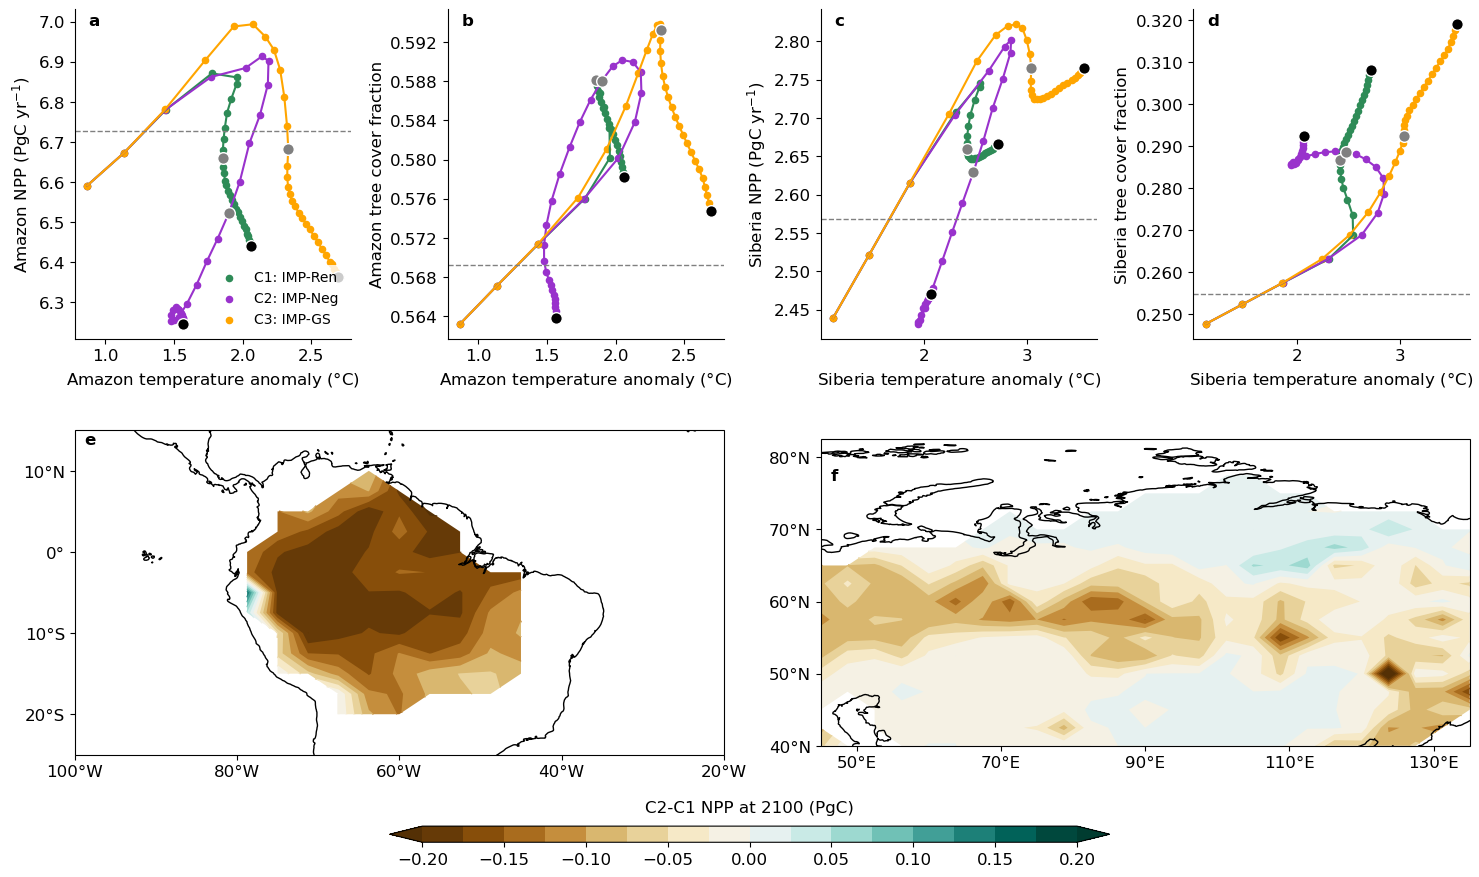

In [19]:
overshoot_peak_ms = 70
linealpha=1
lineps=20
endofline_size=70

frac_mean_amazon = frac_area_list_amazon[0]
npp_mean_amazon = npp_area_list_amazon[0]
frac_mean_siberia = frac_area_list_siberia[0]
npp_mean_siberia = npp_area_list_siberia[0]

amazon_conv = amazon_area / 1e12
siberia_conv = siberia_area / 1e12

levels = np.arange(-0.2,0.225,0.025)

X = [ (1,1), (2,2), (3,3), (4,4),
      (5,6),        (7,8)]


fig = plt.figure(figsize=(18, 8.5))
gs = fig.add_gridspec(2, 4, height_ratios=[1, 1])

ax = fig.add_subplot(gs[0, 1])
# ax.set_title('Amazon Tree fraction')
ax.scatter(temp_median_amazon_anomaly_c1, np.sum(frac_mean_amazon['c1']['0.5'][-decs:, :5].data, axis=1), color='seagreen', label="C1: IMP-Ren", s=lineps)
ax.plot(temp_median_amazon_anomaly_c1, np.sum(frac_mean_amazon['c1']['0.5'][-decs:, :5].data, axis=1), color='seagreen', alpha=linealpha)
ax.scatter(temp_median_amazon_anomaly_c2, np.sum(frac_mean_amazon['c2']['0.5'][-decs:, :5].data, axis=1), color='darkorchid', label="C2: IMP-Neg", s=lineps)
ax.plot(temp_median_amazon_anomaly_c2, np.sum(frac_mean_amazon['c2']['0.5'][-decs:, :5].data, axis=1), color='darkorchid', alpha=linealpha)
ax.scatter(temp_median_amazon_anomaly_c3, np.sum(frac_mean_amazon['c3']['0.5'][-decs:, :5].data, axis=1), color='orange', label="C3: IMP-GS", s=lineps)
ax.plot(temp_median_amazon_anomaly_c3, np.sum(frac_mean_amazon['c3']['0.5'][-decs:, :5].data, axis=1), color='orange', alpha=linealpha)

# Plot overshoot peaks + ends
ax.scatter(temp_median_amazon_anomaly_c1[-20], np.sum(frac_mean_amazon['c1']['0.5'][-decs:, :5].data, axis=1)[-20], color='grey', edgecolor='white', marker='o', zorder=2, s=overshoot_peak_ms)
ax.scatter(temp_median_amazon_anomaly_c2[-20], np.sum(frac_mean_amazon['c2']['0.5'][-decs:, :5].data, axis=1)[-20], color='grey', edgecolor='white', marker='o', zorder=2, s=overshoot_peak_ms)
ax.scatter(temp_median_amazon_anomaly_c3[-20], np.sum(frac_mean_amazon['c3']['0.5'][-decs:, :5].data, axis=1)[-20], color='grey', edgecolor='white', marker='o', zorder=2, s=overshoot_peak_ms)

ax.scatter(temp_median_amazon_anomaly_c1[-1], np.sum(frac_mean_amazon['c1']['0.5'][-decs:, :5].data, axis=1)[-1], color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)
ax.scatter(temp_median_amazon_anomaly_c2[-1], np.sum(frac_mean_amazon['c2']['0.5'][-decs:, :5].data, axis=1)[-1], color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)
ax.scatter(temp_median_amazon_anomaly_c3[-1], np.sum(frac_mean_amazon['c3']['0.5'][-decs:, :5].data, axis=1)[-1], color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)

ax.set_xlabel('Amazon temperature anomaly ($\degree$C)')
ax.set_ylabel('Amazon tree cover fraction')

ax.axhline(frac_baseline_amazon, linestyle='--', lw=1, color='grey')

ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_locator(MultipleLocator(0.004))
ax.yaxis.set_minor_formatter(FormatStrFormatter("%.3f"))

ax.spines[['right', 'top']].set_visible(False)
ax.text(0.05, 0.95, 'b', transform=ax.transAxes, color='black', weight='bold')

ax = fig.add_subplot(gs[0, 0])
# ax.set_title('Amazon NPP')
ax.scatter(temp_median_amazon_anomaly_c1, npp_mean_amazon['c1']['0.5'][-decs:].data*amazon_conv, color='seagreen', s=lineps, label="C1: IMP-Ren")
ax.plot(temp_median_amazon_anomaly_c1, npp_mean_amazon['c1']['0.5'][-decs:].data*amazon_conv, color='seagreen', alpha=linealpha)
ax.scatter(temp_median_amazon_anomaly_c2, npp_mean_amazon['c2']['0.5'][-decs:].data*amazon_conv, color='darkorchid', s=lineps, label="C2: IMP-Neg")
ax.plot(temp_median_amazon_anomaly_c2, npp_mean_amazon['c2']['0.5'][-decs:].data*amazon_conv, color='darkorchid', alpha=linealpha)
ax.scatter(temp_median_amazon_anomaly_c3, npp_mean_amazon['c3']['0.5'][-decs:].data*amazon_conv, color='orange', s=lineps, label="C3: IMP-GS")
ax.plot(temp_median_amazon_anomaly_c3, npp_mean_amazon['c3']['0.5'][-decs:].data*amazon_conv, color='orange', alpha=linealpha)

# Plot overshoot peak
ax.scatter(temp_median_amazon_anomaly_c1[-20], npp_mean_amazon['c1']['0.5'][-decs:].data[-20]*amazon_conv, color='grey', marker='o', edgecolor='white', zorder=2, s=overshoot_peak_ms)
ax.scatter(temp_median_amazon_anomaly_c2[-20], npp_mean_amazon['c2']['0.5'][-decs:].data[-20]*amazon_conv, color='grey', marker='o', edgecolor='white', zorder=2, s=overshoot_peak_ms)
ax.scatter(temp_median_amazon_anomaly_c3[-20], npp_mean_amazon['c3']['0.5'][-decs:].data[-20]*amazon_conv, color='grey', marker='o', edgecolor='white', zorder=2, s=overshoot_peak_ms)

ax.scatter(temp_median_amazon_anomaly_c1[-1], npp_mean_amazon['c1']['0.5'][-decs:].data[-1]*amazon_conv, color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)
ax.scatter(temp_median_amazon_anomaly_c2[-1], npp_mean_amazon['c2']['0.5'][-decs:].data[-1]*amazon_conv, color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)
ax.scatter(temp_median_amazon_anomaly_c3[-1], npp_mean_amazon['c3']['0.5'][-decs:].data[-1]*amazon_conv, color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)

ax.set_xlabel('Amazon temperature anomaly ($\degree$C)')
ax.set_ylabel('Amazon NPP (PgC yr$^{-1}$)')

ax.text(0.05, 0.95, 'a', transform=ax.transAxes, color='black', weight='bold')

ax.spines[['right', 'top']].set_visible(False)
ax.axhline(npp_baseline_amazon, linestyle='--', lw=1, color='grey')

plt.legend(loc='lower right', edgecolor='none', prop={'size': 10})

ax = fig.add_subplot(gs[0, 3])
# ax.set_title('Siberia Tree fraction')
ax.scatter(temp_median_siberia_anomaly_c1, np.sum(frac_mean_siberia['c1']['0.5'][-decs:, :5].data, axis=1), color='seagreen', s=lineps)
ax.plot(temp_median_siberia_anomaly_c1, np.sum(frac_mean_siberia['c1']['0.5'][-decs:, :5].data, axis=1), color='seagreen', alpha=linealpha)
ax.scatter(temp_median_siberia_anomaly_c2, np.sum(frac_mean_siberia['c2']['0.5'][-decs:, :5].data, axis=1), color='darkorchid', s=lineps)
ax.plot(temp_median_siberia_anomaly_c2, np.sum(frac_mean_siberia['c2']['0.5'][-decs:, :5].data, axis=1), color='darkorchid', alpha=linealpha)
ax.scatter(temp_median_siberia_anomaly_c3, np.sum(frac_mean_siberia['c3']['0.5'][-decs:, :5].data, axis=1), color='orange', s=lineps)
ax.plot(temp_median_siberia_anomaly_c3, np.sum(frac_mean_siberia['c3']['0.5'][-decs:, :5].data, axis=1), color='orange', alpha=linealpha)

# Plot overshoot peaks + ends
ax.scatter(temp_median_siberia_anomaly_c1[-20], np.sum(frac_mean_siberia['c1']['0.5'][-decs:, :5].data, axis=1)[-20], color='grey', marker='o', edgecolor='white', zorder=2, s=overshoot_peak_ms)
ax.scatter(temp_median_siberia_anomaly_c2[-20], np.sum(frac_mean_siberia['c2']['0.5'][-decs:, :5].data, axis=1)[-20], color='grey', marker='o', edgecolor='white', zorder=2, s=overshoot_peak_ms)
ax.scatter(temp_median_siberia_anomaly_c3[-20], np.sum(frac_mean_siberia['c3']['0.5'][-decs:, :5].data, axis=1)[-20], color='grey', marker='o', edgecolor='white', zorder=2, s=overshoot_peak_ms)

ax.scatter(temp_median_siberia_anomaly_c1[-1], np.sum(frac_mean_siberia['c1']['0.5'][-decs:, :5].data, axis=1)[-1], color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)
ax.scatter(temp_median_siberia_anomaly_c2[-1], np.sum(frac_mean_siberia['c2']['0.5'][-decs:, :5].data, axis=1)[-1], color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)
ax.scatter(temp_median_siberia_anomaly_c3[-1], np.sum(frac_mean_siberia['c3']['0.5'][-decs:, :5].data, axis=1)[-1], color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)

ax.set_xlabel('Siberia temperature anomaly ($\degree$C)')
ax.set_ylabel('Siberia tree cover fraction')

ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
# ax.yaxis.set_major_locator(MultipleLocator(0.004))
ax.yaxis.set_minor_formatter(FormatStrFormatter("%.3f"))

ax.spines[['right', 'top']].set_visible(False)
ax.text(0.05, 0.95, 'd', transform=ax.transAxes, color='black', weight='bold')

ax.axhline(frac_baseline_siberia, linestyle='--', lw=1, color='grey')

ax = fig.add_subplot(gs[0, 2])
# ax.set_title('Siberia NPP')
ax.scatter(temp_median_siberia_anomaly_c1, npp_mean_siberia['c1']['0.5'][-decs:].data*siberia_conv, color='seagreen', s=lineps)
ax.plot(temp_median_siberia_anomaly_c1, npp_mean_siberia['c1']['0.5'][-decs:].data*siberia_conv, color='seagreen', alpha=linealpha)
ax.scatter(temp_median_siberia_anomaly_c2, npp_mean_siberia['c2']['0.5'][-decs:].data*siberia_conv, color='darkorchid', s=lineps)
ax.plot(temp_median_siberia_anomaly_c2, npp_mean_siberia['c2']['0.5'][-decs:].data*siberia_conv, color='darkorchid', alpha=linealpha)
ax.scatter(temp_median_siberia_anomaly_c3, npp_mean_siberia['c3']['0.5'][-decs:].data*siberia_conv, color='orange', s=lineps)
ax.plot(temp_median_siberia_anomaly_c3, npp_mean_siberia['c3']['0.5'][-decs:].data*siberia_conv, color='orange', alpha=linealpha)

# Plot 2100 points
ax.scatter(temp_median_siberia_anomaly_c1[-20], npp_mean_siberia['c1']['0.5'][-decs:].data[-20]*siberia_conv, color='grey', marker='o', edgecolor='white', zorder=2, s=overshoot_peak_ms)
ax.scatter(temp_median_siberia_anomaly_c2[-20], npp_mean_siberia['c2']['0.5'][-decs:].data[-20]*siberia_conv, color='grey', marker='o', edgecolor='white', zorder=2, s=overshoot_peak_ms)
ax.scatter(temp_median_siberia_anomaly_c3[-20], npp_mean_siberia['c3']['0.5'][-decs:].data[-20]*siberia_conv, color='grey', marker='o', edgecolor='white', zorder=2, s=overshoot_peak_ms)

ax.scatter(temp_median_siberia_anomaly_c1[-1], npp_mean_siberia['c1']['0.5'][-decs:].data[-1]*siberia_conv, color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)
ax.scatter(temp_median_siberia_anomaly_c2[-1], npp_mean_siberia['c2']['0.5'][-decs:].data[-1]*siberia_conv, color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)
ax.scatter(temp_median_siberia_anomaly_c3[-1], npp_mean_siberia['c3']['0.5'][-decs:].data[-1]*siberia_conv, color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)

ax.set_xlabel('Siberia temperature anomaly ($\degree$C)')
ax.set_ylabel('Siberia NPP (PgC yr$^{-1}$)')

ax.spines[['right', 'top']].set_visible(False)
ax.text(0.05, 0.95, 'c', transform=ax.transAxes, color='black', weight='bold')

ax.axhline(npp_baseline_siberia, linestyle='--', lw=1, color='grey')
     
# Now plot the maps
    
ax = fig.add_subplot(gs[1, :2], projection=ccrs.PlateCarree())
# ax.add_feature(cart.feature.OCEAN, zorder=9, edgecolor='k', facecolor="none")
ax.coastlines()

cont = iplt.contourf(
    npp_area_mean['amazon_map']['C2-IMP-Neg']['0.5'][-20] - npp_area_mean['amazon_map']['C1-IMP-Ren']['0.5'][-20], 
    cmap='BrBG', 
    levels=levels, 
    extend='both'
)
# cont = iplt.pcolormesh(
#     npp_area_mean['amazon_map']['C2-IMP-Neg']['0.5'][-20] - npp_area_mean['amazon_map']['C1-IMP-Ren']['0.5'][-20], 
#     cmap='BrBG', 
# )

ax.set_xticks([-100, -80, -60, -40, -20], crs=ccrs.PlateCarree())
ax.set_xticklabels(['100°W', '80°W', '60°W', '40°W', '20°W'])
ax.set_xlim([-100, -20])
ax.set_yticks([-30, -20, -10, 0, 10], crs=ccrs.PlateCarree())
ax.set_yticklabels(['30°S', '20°S', '10°S', '0°', '10°N'])
ax.set_ylim([-25, 15])
ax.annotate("e", xy=(0.015, 0.97), xycoords='axes fraction', weight='bold', ha='left', va='center',color="black",zorder=10)
ax.spines[['right', 'top']].set_visible(False)

ax = fig.add_subplot(gs[1, 2:4], projection=ccrs.PlateCarree())
# ax.add_feature(cart.feature.OCEAN, zorder=9, edgecolor='k', facecolor="none")
ax.coastlines()

cont = iplt.contourf(
    npp_area_mean['siberia_map']['C2-IMP-Neg']['0.5'][-20] - npp_area_mean['siberia_map']['C1-IMP-Ren']['0.5'][-20], 
    cmap='BrBG', 
    levels=levels, 
    extend='both'
)

ax.set_xticks([50, 70, 90, 110, 130], crs=ccrs.PlateCarree())
ax.set_xticklabels(['50°E', '70°E', '90°E', '110°E', '130°E'])
ax.set_yticks([40, 50, 60, 70, 80], crs=ccrs.PlateCarree())
ax.set_yticklabels(['40°N', '50°N', '60°N', '70°N', '80°N'])
ax.annotate("f", xy=(0.015, 0.88), xycoords='axes fraction', weight='bold', ha='left', va='center',color="black",zorder=10) 
ax.spines[['right', 'top']].set_visible(False)

cbar_ax = fig.add_axes([0.3, -0.1, 0.4, 0.019])
fig.colorbar(cont, cax=cbar_ax, orientation='horizontal')
fig.text(0.5,-0.065,"C2-C1 NPP at 2100 (PgC)",ha="center")
fig.subplots_adjust(wspace=0.35, hspace=0.27, bottom=0.0)

plt.savefig('../plot_files_NCC/fig2_new.pdf', bbox_inches='tight', format='pdf', dpi=1000)

## Extended Data Figure 1

/var/folders/sb/qqz4tyy142q_jb2y2lj_1x580000gn/T/ipykernel_6509/88962207.py:99: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.35, hspace=0.27,bottom=0.0)
/var/folders/sb/qqz4tyy142q_jb2y2lj_1x580000gn/T/ipykernel_6509/88962207.py:107: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.35, hspace=0.27,bottom=0.0)


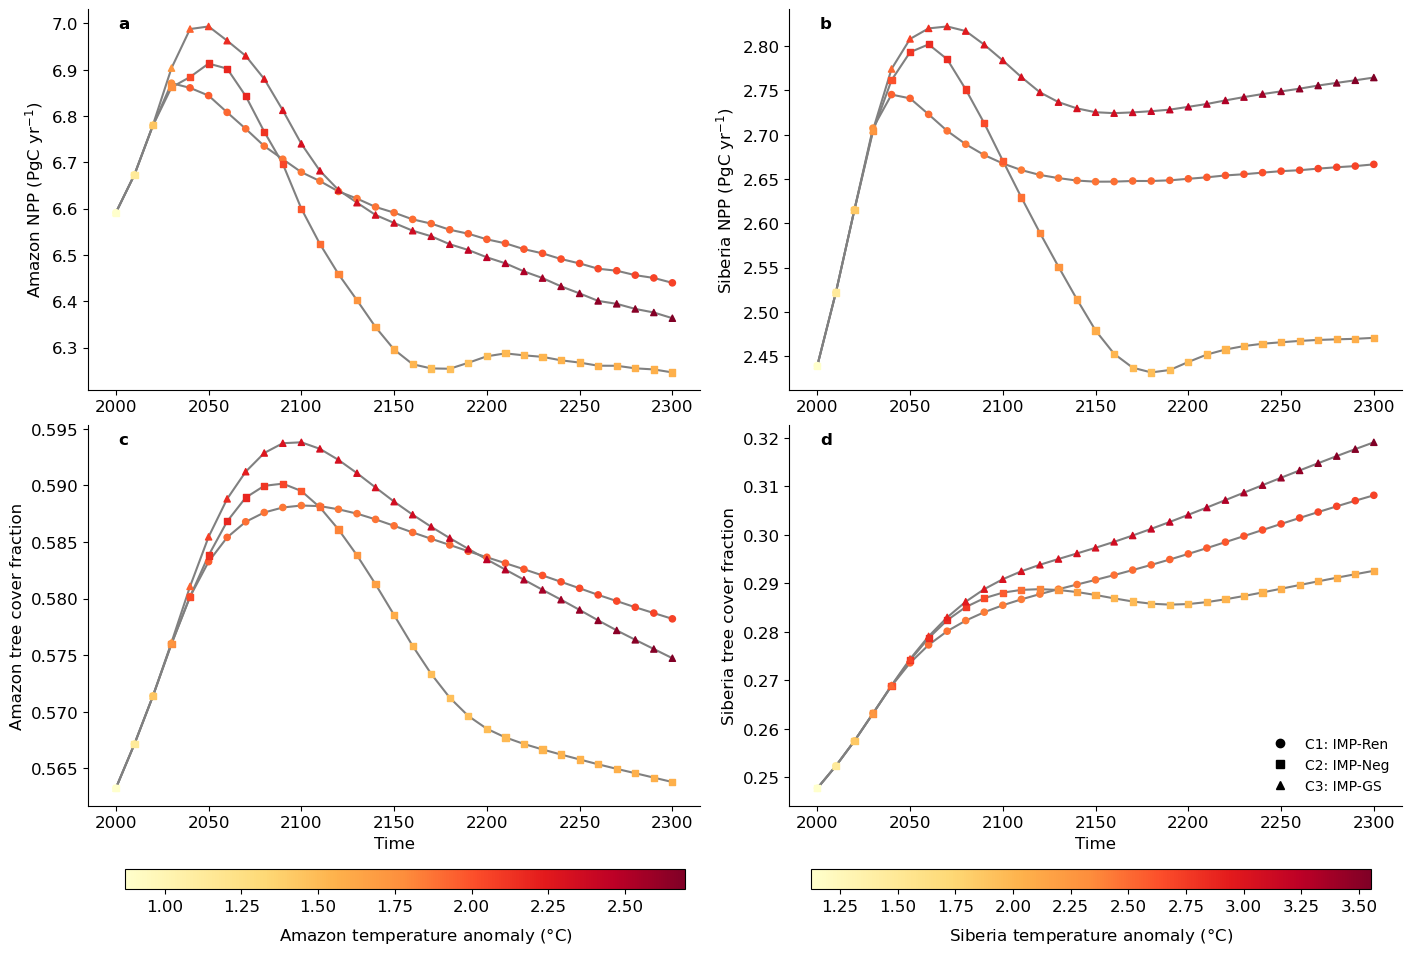

In [20]:
overshoot_peak_ms = 70
linealpha=1
lineps=20
endofline_size=70

frac_mean_amazon = frac_area_list_amazon[0]
npp_mean_amazon = npp_area_list_amazon[0]
frac_mean_siberia = frac_area_list_siberia[0]
npp_mean_siberia = npp_area_list_siberia[0]

amazon_conv = amazon_area / 1e12
siberia_conv = siberia_area / 1e12

a_vmin = np.min([temp_median_amazon_anomaly_c1, temp_median_amazon_anomaly_c2, temp_median_amazon_anomaly_c3])
a_vmax = np.max([temp_median_amazon_anomaly_c1, temp_median_amazon_anomaly_c2, temp_median_amazon_anomaly_c3])

s_vmin = np.min([temp_median_siberia_anomaly_c1, temp_median_siberia_anomaly_c2, temp_median_siberia_anomaly_c3])
s_vmax = np.max([temp_median_siberia_anomaly_c1, temp_median_siberia_anomaly_c2, temp_median_siberia_anomaly_c3])

levels = np.arange(-0.4,0.45,0.05)
fig = plt.figure(figsize=(14, 8.5), layout='compressed')

ax = fig.add_subplot(223)
# ax.set_title('Amazon Tree fraction')
ax.plot(time, np.sum(frac_mean_amazon['c1']['0.5'][-decs:, :5].data, axis=1), color='grey', alpha=linealpha, zorder=0)
ax.scatter(time, np.sum(frac_mean_amazon['c1']['0.5'][-decs:, :5].data, axis=1), vmin=a_vmin, vmax=a_vmax, c=temp_median_amazon_anomaly_c1, cmap='YlOrRd', label="C1: IMP-Ren", s=lineps, zorder=1)
ax.plot(time, np.sum(frac_mean_amazon['c2']['0.5'][-decs:, :5].data, axis=1), color='grey', alpha=linealpha, zorder=0)
ax.scatter(time, np.sum(frac_mean_amazon['c2']['0.5'][-decs:, :5].data, axis=1), vmin=a_vmin, vmax=a_vmax, marker='s', c=temp_median_amazon_anomaly_c2, cmap='YlOrRd', label="C2: IMP-Neg", s=lineps, zorder=1)
ax.plot(time, np.sum(frac_mean_amazon['c3']['0.5'][-decs:, :5].data, axis=1), color='grey', alpha=linealpha, zorder=0)
im1 = ax.scatter(time, np.sum(frac_mean_amazon['c3']['0.5'][-decs:, :5].data, axis=1), vmin=a_vmin, vmax=a_vmax, marker='^', c=temp_median_amazon_anomaly_c3, cmap='YlOrRd', label="C3: IMP-GS", s=lineps, zorder=1)

ax.set_xlabel('Time')
ax.set_ylabel('Amazon tree cover fraction')

ax.spines[['right', 'top']].set_visible(False)
ax.text(0.05, 0.95, 'c', transform=ax.transAxes, color='black', weight='bold')



ax = fig.add_subplot(224)
# ax.set_title('Amazon Tree fraction')
ax.scatter(time, np.sum(frac_mean_siberia['c1']['0.5'][-decs:, :5].data, axis=1), vmin=s_vmin, vmax=s_vmax, c=temp_median_siberia_anomaly_c1, cmap='YlOrRd', label="C1: IMP-Ren", s=lineps, zorder=1)
ax.plot(time, np.sum(frac_mean_siberia['c1']['0.5'][-decs:, :5].data, axis=1), color='grey', alpha=linealpha, zorder=0)
ax.scatter(time, np.sum(frac_mean_siberia['c2']['0.5'][-decs:, :5].data, axis=1), marker='s', vmin=s_vmin, vmax=s_vmax, c=temp_median_siberia_anomaly_c2, cmap='YlOrRd', label="C2: IMP-Neg", s=lineps, zorder=1)
ax.plot(time, np.sum(frac_mean_siberia['c2']['0.5'][-decs:, :5].data, axis=1), color='grey', alpha=linealpha, zorder=0)
im2 = ax.scatter(time, np.sum(frac_mean_siberia['c3']['0.5'][-decs:, :5].data, axis=1), marker='^', vmin=s_vmin, vmax=s_vmax, c=temp_median_siberia_anomaly_c3, cmap='YlOrRd', label="C3: IMP-GS", s=lineps, zorder=1)
ax.plot(time, np.sum(frac_mean_siberia['c3']['0.5'][-decs:, :5].data, axis=1), color='grey', alpha=linealpha, zorder=0)

ax.set_xlabel('Time')
ax.set_ylabel('Siberia tree cover fraction')

ax.spines[['right', 'top']].set_visible(False)
ax.text(0.05, 0.95, 'd', transform=ax.transAxes, color='black', weight='bold')

proxy_artists = []
for marker in ['o', 's', '^']:
    proxy = plt.plot([], [], marker=marker, ls='', 
                     markerfacecolor='black', markeredgecolor='black')[0]
    proxy_artists.append(proxy)

plt.legend(
    proxy_artists, 
    ['C1: IMP-Ren', 'C2: IMP-Neg', 'C3: IMP-GS'], 
    loc='lower right', 
    edgecolor='none', 
    prop={'size': 10}
)

ax = fig.add_subplot(221)
ax.scatter(time, npp_mean_amazon['c1']['0.5'][-decs:].data*amazon_conv,cmap='YlOrRd', vmin=a_vmin, vmax=a_vmax, c=temp_median_amazon_anomaly_c1, s=lineps, zorder=1)
ax.plot(time, npp_mean_amazon['c1']['0.5'][-decs:].data*amazon_conv, color='grey', alpha=linealpha, zorder=0)
ax.scatter(time, npp_mean_amazon['c2']['0.5'][-decs:].data*amazon_conv,marker='s', cmap='YlOrRd', vmin=a_vmin, vmax=a_vmax, c=temp_median_amazon_anomaly_c2, s=lineps, zorder=1)
ax.plot(time, npp_mean_amazon['c2']['0.5'][-decs:].data*amazon_conv, color='grey', alpha=linealpha, zorder=0)
ax.scatter(time, npp_mean_amazon['c3']['0.5'][-decs:].data*amazon_conv, marker='^', cmap='YlOrRd', vmin=a_vmin, vmax=a_vmax, c=temp_median_amazon_anomaly_c3, s=lineps, zorder=1)
ax.plot(time, npp_mean_amazon['c3']['0.5'][-decs:].data*amazon_conv, color='grey', alpha=linealpha, zorder=0)

ax.set_ylabel('Amazon NPP (PgC yr$^{-1}$)')

ax.spines[['right', 'top']].set_visible(False)
ax.text(0.05, 0.95, 'a', transform=ax.transAxes, color='black', weight='bold')


ax = fig.add_subplot(222)
ax.scatter(time, npp_mean_siberia['c1']['0.5'][-decs:].data*siberia_conv, cmap='YlOrRd', vmin=s_vmin, vmax=s_vmax, c=temp_median_siberia_anomaly_c1, s=lineps, zorder=1)
ax.plot(time, npp_mean_siberia['c1']['0.5'][-decs:].data*siberia_conv, color='grey', alpha=linealpha, zorder=0)
ax.scatter(time, npp_mean_siberia['c2']['0.5'][-decs:].data*siberia_conv, marker='s', cmap='YlOrRd', vmin=s_vmin, vmax=s_vmax, c=temp_median_siberia_anomaly_c2, s=lineps, zorder=1)
ax.plot(time, npp_mean_siberia['c2']['0.5'][-decs:].data*siberia_conv, color='grey', alpha=linealpha, zorder=0)
ax.scatter(time, npp_mean_siberia['c3']['0.5'][-decs:].data*siberia_conv, marker='^', cmap='YlOrRd', vmin=s_vmin, vmax=s_vmax, c=temp_median_siberia_anomaly_c3, s=lineps, zorder=1)
ax.plot(time, npp_mean_siberia['c3']['0.5'][-decs:].data*siberia_conv, color='grey', alpha=linealpha, zorder=0)

ax.set_ylabel('Siberia NPP (PgC yr$^{-1}$)')

ax.spines[['right', 'top']].set_visible(False)
ax.text(0.05, 0.95, 'b', transform=ax.transAxes, color='black', weight='bold')

cbar_ax = fig.add_axes([0.085, -0.04, 0.4, 0.024])
fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
fig.text(0.3, -0.1,"Amazon temperature anomaly ($\degree$C)",ha="center")
fig.subplots_adjust(wspace=0.35, hspace=0.27,bottom=0.0)

cbar_ax = fig.add_axes([0.575, -0.04, 0.4, 0.024])
cbar = fig.colorbar(im2, cax=cbar_ax, orientation='horizontal')
cbar_ticks = [1.25, 1.50, 1.75, 2.00, 2.25, 2.50, 2.75, 3.00, 3.25, 3.50]  # Example locations for the extra ticks
cbar.set_ticks(cbar_ticks)
# cbar.set_ticklabels(['Extra 1', 'Extra 2'])
fig.text(0.775, -0.1,"Siberia temperature anomaly ($\degree$C)",ha="center")
fig.subplots_adjust(wspace=0.35, hspace=0.27,bottom=0.0)

plt.savefig('../plot_files_NCC/ext_fig1_new.pdf', dpi=1000, bbox_inches='tight')


In [21]:
surface_types = ["BdlDcd", "BdlEvgTrop", "BdlEvgTemp", "NdlDcd", "NdlEvg",
                 "c3grass", "c3crop", "c3pasture", "c4grass", "c4crop",
                 "c4pasture", "shrubDcd", "shrubEvg", "urban", "lake",
                 "soil", "ice"]
c1_pfts = {}
c1_lower_pfts = {}
c2_pfts = {}
c3_pfts = {}
for i, s in enumerate(surface_types):
    c1_pfts[s] = area_avg_cube(extract_amazon_basin(frac_stats['C1-IMP-Ren']['0.5'][0], amazon_mask))[-decs:, i].data
    c1_lower_pfts[s] = area_avg_cube(extract_amazon_basin(frac_stats['C1-IMP-Ren']['0.25'][0], amazon_mask))[-decs:, i].data
    c2_pfts[s] = area_avg_cube(extract_amazon_basin(frac_stats['C2-IMP-Neg']['0.5'][0], amazon_mask))[-decs:, i].data
    c3_pfts[s] = area_avg_cube(extract_amazon_basin(frac_stats['C3-IMP-GS']['0.5'][0], amazon_mask))[-decs:, i].data


/Users/gregorymunday/anaconda3/envs/forest-risks/lib/python3.11/site-packages/iris/analysis/cartography.py:429: IrisDefaultingWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn(
/Users/gregorymunday/anaconda3/envs/forest-risks/lib/python3.11/site-packages/iris/analysis/cartography.py:429: IrisDefaultingWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn(
/Users/gregorymunday/anaconda3/envs/forest-risks/lib/python3.11/site-packages/iris/analysis/cartography.py:429: IrisDefaultingWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn(
/Users/gregorymunday/anaconda3/envs/forest-risks/lib/python3.11/site-packages/iris/analysis/cartography.py:429: IrisDefaultingWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn(
/Users/gregorymunday/anaconda3/envs/forest-risks/lib/python3.11/site-packages/iris/analysis/cartography.py:429: IrisDefaultingWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn(
/Users/gregorymunday/anaconda3/envs/forest-risks/l

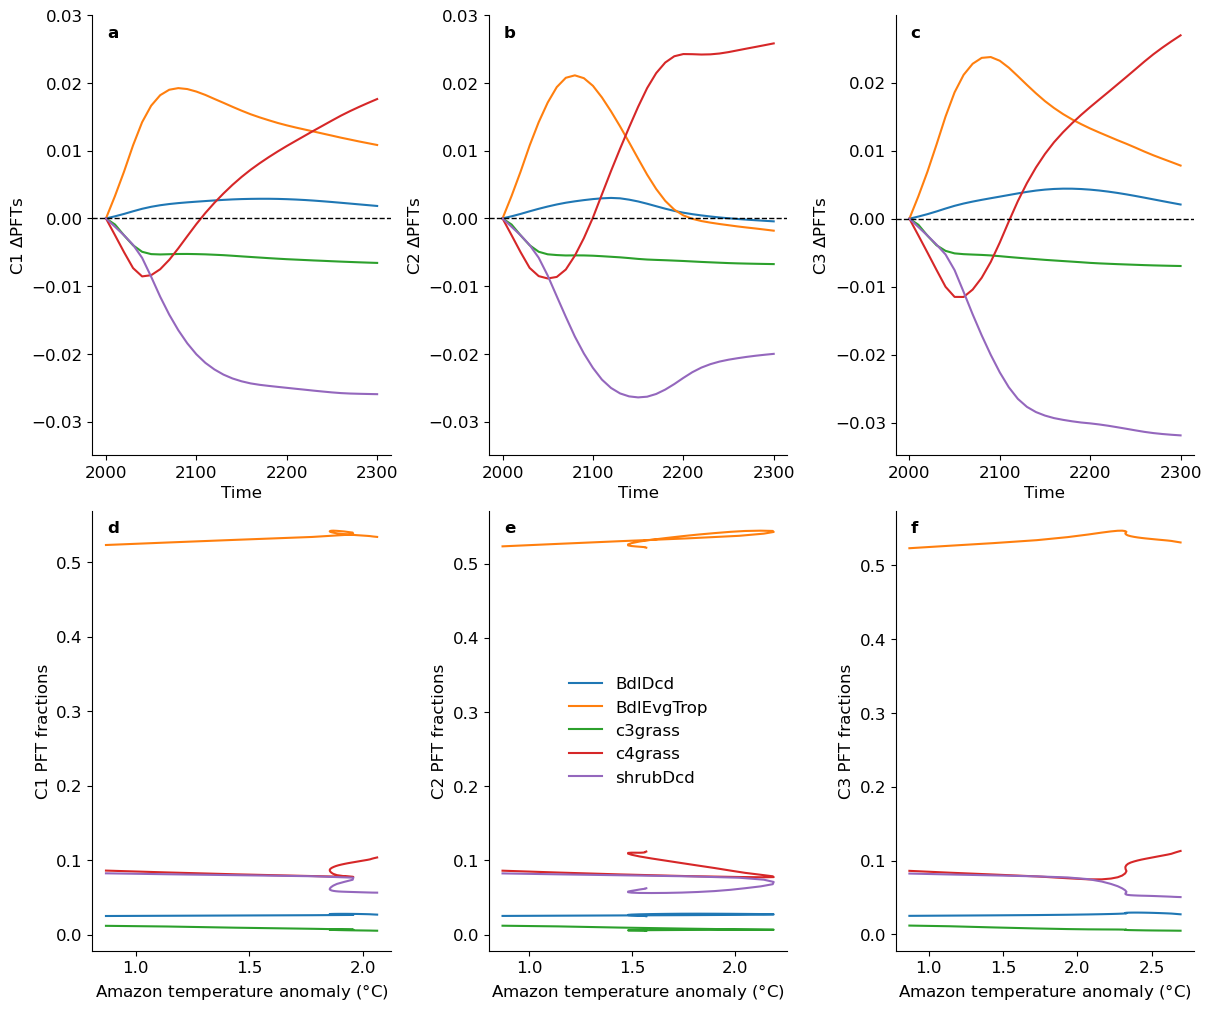

In [22]:
fig = plt.figure(figsize=(12, 10), layout='compressed')

# plot_pfts = ["BdlDcd", "BdlEvgTrop", "BdlEvgTemp", "NdlDcd", "NdlEvg"]
plot_pfts = ["BdlDcd", "BdlEvgTrop",
            "c3grass", "c4grass", "shrubDcd"]
time = np.arange(2000, 2310, 10)

ax = fig.add_subplot(231)
for pft in plot_pfts:
    ax.plot(time, c1_pfts[pft] - c1_pfts[pft][0], label=f'{pft}')

ax.set_ylim([-0.035, 0.03])
ax.set_ylabel('C1 $\Delta$PFTs')
ax.set_xlabel('Time')
ax.spines[['right', 'top']].set_visible(False)
ax.text(0.05, 0.95, 'a', transform=ax.transAxes, color='black', weight='bold')
ax.axhline(0,  color='black', lw=1, ls='--')


ax = fig.add_subplot(232)
for pft in plot_pfts:
    ax.plot(time, c2_pfts[pft] - c2_pfts[pft][0], label=f'{pft}')

ax.set_ylim([-0.035, 0.03])
ax.set_ylabel('C2 $\Delta$PFTs')
ax.set_xlabel('Time')
ax.spines[['right', 'top']].set_visible(False)
ax.text(0.05, 0.95, 'b', transform=ax.transAxes, color='black', weight='bold')
ax.axhline(0,  color='black', lw=1, ls='--')

ax = fig.add_subplot(233)
for pft in plot_pfts:
    ax.plot(time, c3_pfts[pft] - c3_pfts[pft][0], label=f'{pft}')

# ax.set_ylim([-0.035, 0.03])
ax.set_ylabel('C3 $\Delta$PFTs')
ax.set_xlabel('Time')
ax.spines[['right', 'top']].set_visible(False)
ax.text(0.05, 0.95, 'c', transform=ax.transAxes, color='black', weight='bold')
ax.axhline(0,  color='black', lw=1, ls='--')

ax = fig.add_subplot(234)
for pft in plot_pfts:
    # ax.plot(time, c1_pfts[pft] - c1_pfts[pft][0], label=f'{pft}')
    ax.plot(temp_median_amazon_anomaly_c1, c1_pfts[pft], label=f'{pft}')

# ax.set_ylim([-0.035, 0.03])
ax.set_ylabel('C1 PFT fractions')
ax.set_xlabel('Amazon temperature anomaly ($\degree$C)')
ax.spines[['right', 'top']].set_visible(False)
ax.text(0.05, 0.95, 'd', transform=ax.transAxes, color='black', weight='bold')


ax = fig.add_subplot(235)
for pft in plot_pfts:
    # ax.plot(time, c2_pfts[pft] - c2_pfts[pft][0], label=f'{pft}')
    ax.plot(temp_median_amazon_anomaly_c2, c2_pfts[pft], label=f'{pft}')

# ax.set_ylim([-0.035, 0.03])
ax.set_ylabel('C2 PFT fractions')
ax.set_xlabel('Amazon temperature anomaly ($\degree$C)')
ax.spines[['right', 'top']].set_visible(False)
ax.text(0.05, 0.95, 'e', transform=ax.transAxes, color='black', weight='bold')

ax.legend(loc='center', frameon=False,
          fancybox=True)

ax = fig.add_subplot(236)
for pft in plot_pfts:
    # ax.plot(time, c3_pfts[pft] - c3_pfts[pft][0], label=f'{pft}')
    ax.plot(temp_median_amazon_anomaly_c3, c3_pfts[pft], label=f'{pft}')

# ax.set_ylim([-0.035, 0.03])
ax.set_ylabel('C3 PFT fractions')
ax.set_xlabel('Amazon temperature anomaly ($\degree$C)')
ax.spines[['right', 'top']].set_visible(False)
ax.text(0.05, 0.95, 'f', transform=ax.transAxes, color='black', weight='bold')


plt.savefig('../plots/PFT_changes_new.png', dpi=300)

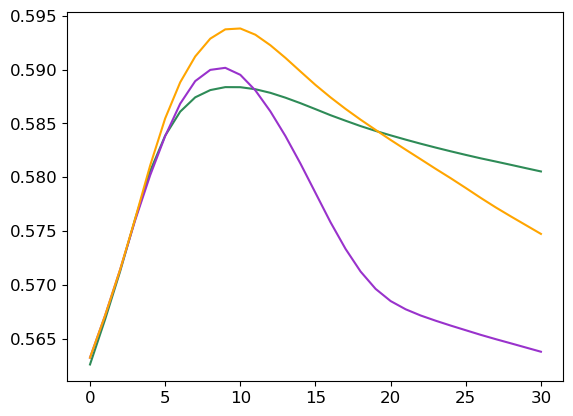

In [23]:
plot_pfts = ["BdlDcd", "BdlEvgTrop", "BdlEvgTemp", "NdlDcd", "NdlEvg"]
c1_response = []
c1_lower_response = []
c2_response = []
c3_response = []
for pft in plot_pfts:
    c1_response.append(c1_pfts[pft])
    c1_lower_response.append(c1_lower_pfts[pft])
    c2_response.append(c2_pfts[pft])
    c3_response.append(c3_pfts[pft])

c1_response = np.sum(c1_response, axis=0)
c1_lower_response = np.sum(c1_lower_response, axis=0)
c2_response = np.sum(c2_response, axis=0)
c3_response = np.sum(c3_response, axis=0)

plt.plot(c1_lower_response, color='seagreen')
plt.plot(c2_response, color='darkorchid')
plt.plot(c3_response, color='orange')

In [ ]:
fig = plt.figure(figsize=(12, 6), layout='constrained')

time = np.arange(2000, 2310, 10)
ax = fig.add_subplot(121)
ax.plot(time, gtemp_dict['C1-IMP-Ren']['0.25'][-31:], color='seagreen', label='C1:IMP-Ren S25')
ax.plot(time, gtemp_dict['C2-IMP-Neg']['0.5'][-31:], color='darkorchid', label='C2:IMP-Neg S50')
# ax.plot(time, gtemp_dict['C3-IMP-GS']['0.5'][-31:], color='orange', label='C3:IMP-GS S50')
ax.axhline(1.5, color='firebrick', linestyle='--', lw='1')

ax.set_xlabel('Time')
ax.set_ylabel('GMST anomaly relative to pre-industrial ($\degree$C)')
ax.spines[['right', 'top']].set_visible(False)
ax.text(0.05, 0.95, 'a', transform=ax.transAxes, color='black', weight='bold')
ax.legend(loc='lower right', frameon=False, fancybox=True)

ax = fig.add_subplot(122)
ax.plot(time, c1_lower_response, color='seagreen')
ax.plot(time, c2_response, color='darkorchid')
# ax.plot(time, c3_response, color='orange')
ax.axhline(frac_baseline_amazon, linestyle='--', lw=1, color='grey')

ax.set_xlabel('Time')
ax.set_ylabel('Amazon tree fraction')
ax.spines[['right', 'top']].set_visible(False)
ax.text(0.05, 0.95, 'b', transform=ax.transAxes, color='black', weight='bold')

plt.savefig('../plots/past_history.png')

In [25]:
surface_types = ["BdlDcd", "BdlEvgTrop", "BdlEvgTemp", "NdlDcd", "NdlEvg",
                 "c3grass", "c3crop", "c3pasture", "c4grass", "c4crop",
                 "c4pasture", "shrubDcd", "shrubEvg", "urban", "lake",
                 "soil", "ice"]
c1_boreal_pfts = {}
c2_boreal_pfts = {}
c3_boreal_pfts = {}
for i, s in enumerate(surface_types):
    c1_boreal_pfts[s] = area_avg_cube(ext(frac_stats['C1-IMP-Ren']['0.5'][0], region['siberia']))[-decs:, i].data
    c2_boreal_pfts[s] = area_avg_cube(ext(frac_stats['C2-IMP-Neg']['0.5'][0], region['siberia']))[-decs:, i].data
    c3_boreal_pfts[s] = area_avg_cube(ext(frac_stats['C3-IMP-GS']['0.5'][0], region['siberia']))[-decs:, i].data

/Users/gregorymunday/anaconda3/envs/forest-risks/lib/python3.11/site-packages/iris/analysis/cartography.py:429: IrisDefaultingWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn(
/Users/gregorymunday/anaconda3/envs/forest-risks/lib/python3.11/site-packages/iris/analysis/cartography.py:429: IrisDefaultingWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn(
/Users/gregorymunday/anaconda3/envs/forest-risks/lib/python3.11/site-packages/iris/analysis/cartography.py:429: IrisDefaultingWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn(
/Users/gregorymunday/anaconda3/envs/forest-risks/lib/python3.11/site-packages/iris/analysis/cartography.py:429: IrisDefaultingWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn(
/Users/gregorymunday/anaconda3/envs/forest-risks/lib/python3.11/site-packages/iris/analysis/cartography.py:429: IrisDefaultingWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn(
/Users/gregorymunday/anaconda3/envs/forest-risks/l

In [30]:
surface_types = ["BdlDcd", "BdlEvgTrop", "BdlEvgTemp", "NdlDcd", "NdlEvg",
                 "c3grass", "c3crop", "c3pasture", "c4grass", "c4crop",
                 "c4pasture", "shrubDcd", "shrubEvg", "urban", "lake",
                 "soil", "ice"]
c1_amazon_pfts = {}
c2_amazon_pfts = {}
c3_amazon_pfts = {}
for i, s in enumerate(surface_types):
    c1_amazon_pfts[s] = area_avg_cube(extract_amazon_basin(frac_stats['C1-IMP-Ren']['0.5'][0], amazon_mask))[-decs:, i].data
    c2_amazon_pfts[s] = area_avg_cube(extract_amazon_basin(frac_stats['C2-IMP-Neg']['0.5'][0], amazon_mask))[-decs:, i].data
    c3_amazon_pfts[s] = area_avg_cube(extract_amazon_basin(frac_stats['C3-IMP-GS']['0.5'][0], amazon_mask))[-decs:, i].data

/Users/gregorymunday/anaconda3/envs/forest-risks/lib/python3.11/site-packages/iris/analysis/cartography.py:429: IrisDefaultingWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn(
/Users/gregorymunday/anaconda3/envs/forest-risks/lib/python3.11/site-packages/iris/analysis/cartography.py:429: IrisDefaultingWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn(
/Users/gregorymunday/anaconda3/envs/forest-risks/lib/python3.11/site-packages/iris/analysis/cartography.py:429: IrisDefaultingWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn(
/Users/gregorymunday/anaconda3/envs/forest-risks/lib/python3.11/site-packages/iris/analysis/cartography.py:429: IrisDefaultingWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn(
/Users/gregorymunday/anaconda3/envs/forest-risks/lib/python3.11/site-packages/iris/analysis/cartography.py:429: IrisDefaultingWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn(
/Users/gregorymunday/anaconda3/envs/forest-risks/l

## Supplementary Figure 1

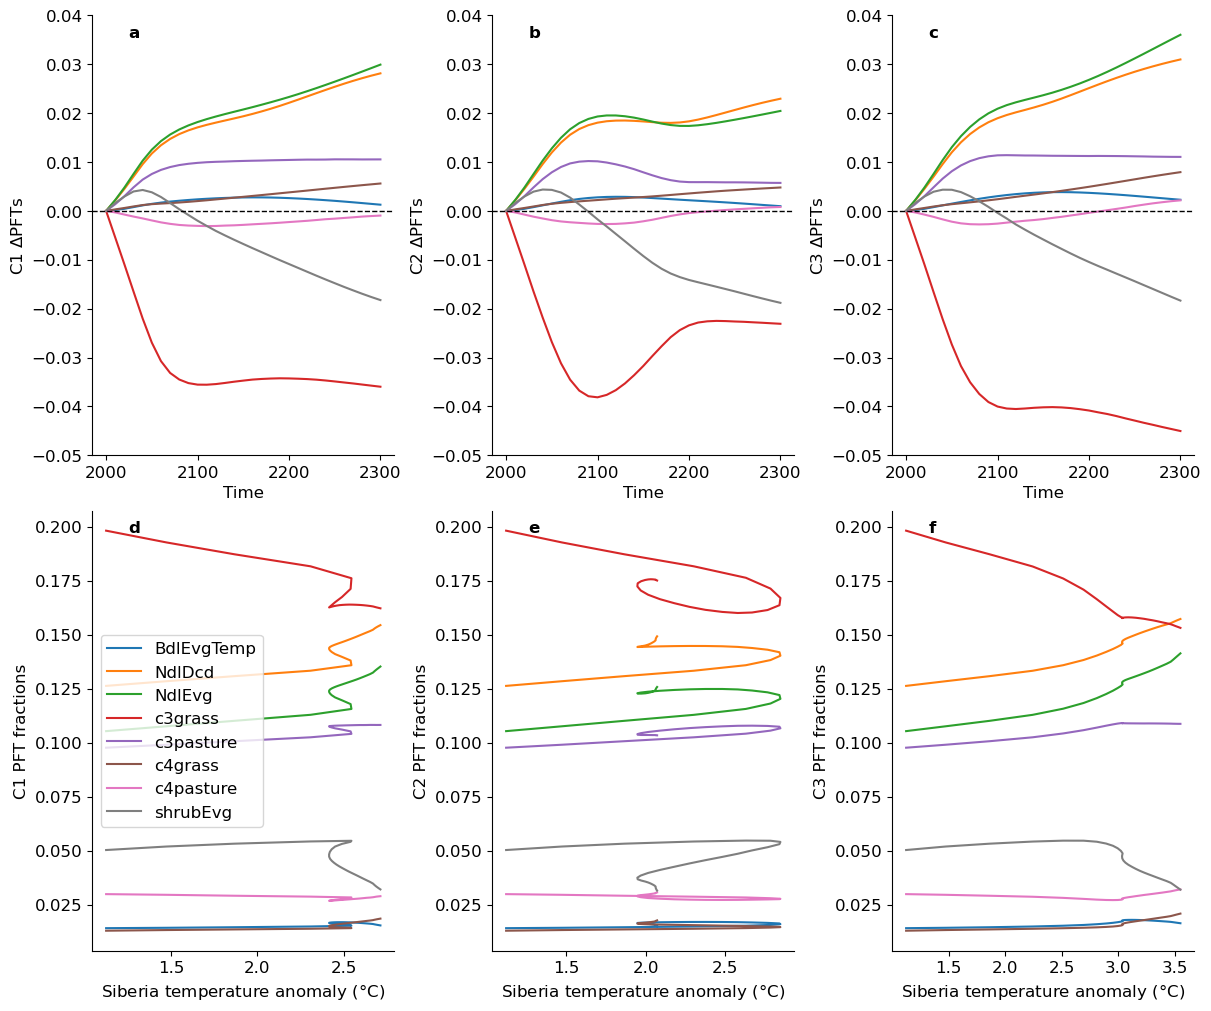

In [31]:
fig = plt.figure(figsize=(12, 10), layout='compressed')

# plot_pfts = ["BdlDcd", "BdlEvgTrop", "BdlEvgTemp", "NdlDcd", "NdlEvg"]
# plot_pfts = ["BdlDcd", "BdlEvgTrop",
#             "c3grass", "c4grass", "shrubDcd"]
plot_pfts = ["BdlEvgTemp", "NdlDcd", "NdlEvg",
                 "c3grass", "c3pasture", "c4grass",
                 "c4pasture", "shrubEvg",]
time = np.arange(2000, 2310, 10)

ax = fig.add_subplot(231)
for pft in plot_pfts:
    ax.plot(time, c1_boreal_pfts[pft] - c1_boreal_pfts[pft][0], label=f'{pft}')

ax.set_ylim([-0.05, 0.04])
ax.set_ylabel('C1 $\Delta$PFTs')
ax.set_xlabel('Time')
ax.spines[['right', 'top']].set_visible(False)
ax.text(0.12, 0.95, 'a', transform=ax.transAxes, color='black', weight='bold')
ax.axhline(0,  color='black', lw=1, ls='--')


ax = fig.add_subplot(232)
for pft in plot_pfts:
    ax.plot(time, c2_boreal_pfts[pft] - c2_boreal_pfts[pft][0], label=f'{pft}')

ax.set_ylim([-0.05, 0.04])
ax.set_ylabel('C2 $\Delta$PFTs')
ax.set_xlabel('Time')
ax.spines[['right', 'top']].set_visible(False)
ax.text(0.12, 0.95, 'b', transform=ax.transAxes, color='black', weight='bold')
ax.axhline(0,  color='black', lw=1, ls='--')

ax = fig.add_subplot(233)
for pft in plot_pfts:
    ax.plot(time, c3_boreal_pfts[pft] - c3_boreal_pfts[pft][0], label=f'{pft}')

ax.set_ylim([-0.05, 0.04])
ax.set_ylabel('C3 $\Delta$PFTs')
ax.set_xlabel('Time')
ax.spines[['right', 'top']].set_visible(False)
ax.text(0.12, 0.95, 'c', transform=ax.transAxes, color='black', weight='bold')
ax.axhline(0,  color='black', lw=1, ls='--')

ax = fig.add_subplot(234)
for pft in plot_pfts:
    # ax.plot(time, c1_pfts[pft] - c1_pfts[pft][0], label=f'{pft}')
    ax.plot(temp_median_siberia_anomaly_c1, c1_boreal_pfts[pft], label=f'{pft}')

# ax.set_ylim([-0.035, 0.03])
ax.set_ylabel('C1 PFT fractions')
ax.set_xlabel('Siberia temperature anomaly ($\degree$C)')
ax.spines[['right', 'top']].set_visible(False)
ax.text(0.12, 0.95, 'd', transform=ax.transAxes, color='black', weight='bold')

ax.legend(loc='center left', frameon=True, fancybox=True)

ax = fig.add_subplot(235)
for pft in plot_pfts:
    # ax.plot(time, c2_pfts[pft] - c2_pfts[pft][0], label=f'{pft}')
    ax.plot(temp_median_siberia_anomaly_c2, c2_boreal_pfts[pft], label=f'{pft}')

# ax.set_ylim([-0.035, 0.03])
ax.set_ylabel('C2 PFT fractions')
ax.set_xlabel('Siberia temperature anomaly ($\degree$C)')
ax.spines[['right', 'top']].set_visible(False)
ax.text(0.12, 0.95, 'e', transform=ax.transAxes, color='black', weight='bold')


ax = fig.add_subplot(236)
for pft in plot_pfts:
    # ax.plot(time, c3_pfts[pft] - c3_pfts[pft][0], label=f'{pft}')
    ax.plot(temp_median_siberia_anomaly_c3, c3_boreal_pfts[pft], label=f'{pft}')

# ax.set_ylim([-0.035, 0.03])
ax.set_ylabel('C3 PFT fractions')
ax.set_xlabel('Siberia temperature anomaly ($\degree$C)')
ax.spines[['right', 'top']].set_visible(False)
ax.text(0.12, 0.95, 'f', transform=ax.transAxes, color='black', weight='bold')


plt.savefig('../plots/supp_figure1_new.png', dpi=300)

## Supplementary Figure 2

In [32]:
a_c1_bc = []
a_c2_bc = []
a_c3_bc = []
s_c1_bc = []
s_c2_bc = []
s_c3_bc = []
for i in range(decs):
    a_c1_init_arr = []
    a_c1_final_arr = []
    a_c2_init_arr = []
    a_c2_final_arr = []
    a_c3_init_arr = []
    a_c3_final_arr = []
    s_c1_init_arr = []
    s_c1_final_arr = []
    s_c2_init_arr = []
    s_c2_final_arr = []
    s_c3_init_arr = []
    s_c3_final_arr = []
    
    for x in c1_amazon_pfts:
        a_c1_init_arr.append(c1_amazon_pfts[x][0])
        a_c1_final_arr.append(c1_amazon_pfts[x][i])
        a_c2_init_arr.append(c2_amazon_pfts[x][0])
        a_c2_final_arr.append(c2_amazon_pfts[x][i])
        a_c3_init_arr.append(c3_amazon_pfts[x][0])
        a_c3_final_arr.append(c3_amazon_pfts[x][i])

    for x in c1_boreal_pfts:
        s_c1_init_arr.append(c1_boreal_pfts[x][0])
        s_c1_final_arr.append(c1_boreal_pfts[x][i])
        s_c2_init_arr.append(c2_boreal_pfts[x][0])
        s_c2_final_arr.append(c2_boreal_pfts[x][i])
        s_c3_init_arr.append(c3_boreal_pfts[x][0])
        s_c3_final_arr.append(c3_boreal_pfts[x][i])

    a_c1_init_arr = np.array(a_c1_init_arr[:-1])
    a_c1_final_arr = np.array(a_c1_final_arr[:-1])
    a_c2_init_arr = np.array(a_c2_init_arr[:-1])
    a_c2_final_arr = np.array(a_c2_final_arr[:-1])
    a_c3_init_arr = np.array(a_c3_init_arr[:-1])
    a_c3_final_arr = np.array(a_c3_final_arr[:-1])

    s_c1_init_arr = np.array(s_c1_init_arr[:-1])
    s_c1_final_arr = np.array(s_c1_final_arr[:-1])
    s_c2_init_arr = np.array(s_c2_init_arr[:-1])
    s_c2_final_arr = np.array(s_c2_final_arr[:-1])
    s_c3_init_arr = np.array(s_c3_init_arr[:-1])
    s_c3_final_arr = np.array(s_c3_final_arr[:-1])

    a_c1_bc.append(scipy.spatial.distance.braycurtis(a_c1_init_arr, a_c1_final_arr))
    a_c2_bc.append(scipy.spatial.distance.braycurtis(a_c2_init_arr, a_c2_final_arr))
    a_c3_bc.append(scipy.spatial.distance.braycurtis(a_c3_init_arr, a_c3_final_arr))

    s_c1_bc.append(scipy.spatial.distance.braycurtis(s_c1_init_arr, s_c1_final_arr))
    s_c2_bc.append(scipy.spatial.distance.braycurtis(s_c2_init_arr, s_c2_final_arr))
    s_c3_bc.append(scipy.spatial.distance.braycurtis(s_c3_init_arr, s_c3_final_arr))
    

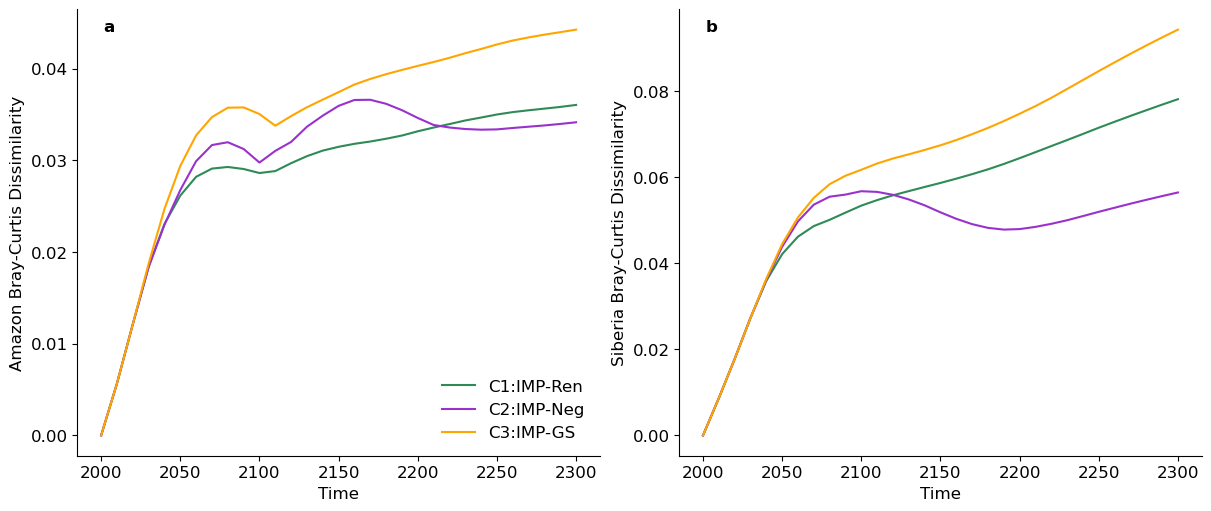

In [33]:
fig = plt.figure(figsize=(12, 5), layout='constrained')

ax = fig.add_subplot(121)

ax.plot(time, a_c1_bc, color='seagreen', label='C1:IMP-Ren')
ax.plot(time, a_c2_bc, color='darkorchid', label='C2:IMP-Neg')
ax.plot(time, a_c3_bc, color='orange', label='C3:IMP-GS')

ax.set_xlabel('Time')
ax.set_ylabel('Amazon Bray-Curtis Dissimilarity')
ax.text(0.05, 0.95, 'a', transform=ax.transAxes, color='black', weight='bold')
ax.legend(loc='lower right', frameon=False, fancybox=True)
ax.spines[['right', 'top']].set_visible(False)

ax = fig.add_subplot(122)

ax.plot(time, s_c1_bc, color='seagreen', label='C1:IMP-Ren')
ax.plot(time, s_c2_bc, color='darkorchid', label='C2:IMP-Neg')
ax.plot(time, s_c3_bc, color='orange', label='C3:IMP-GS')

ax.set_xlabel('Time')
ax.set_ylabel('Siberia Bray-Curtis Dissimilarity')
ax.text(0.05, 0.95, 'b', transform=ax.transAxes, color='black', weight='bold')
ax.spines[['right', 'top']].set_visible(False)

plt.savefig('../plots/supp_figure2_new.png', dpi=300)